# Tweets and Flair

This is an analysis using twitter data scraped during the coronavirus, and will be taking a look at how the tweets in the US changed over time.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FIN = 'data/flair_joined_tweets.csv'

raw = pd.read_csv(FIN)

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

# changing na to None
raw = raw.fillna('None')

raw.head()

,created_at,place,text,pos,ner,sentiment,date,time,hour
0,2020-02-10 07:03:44+00:00,"Paradise, NV",Having a mocha and avoiding coronavirus at the...,"[['Having', 'VBG'], ['a', 'DT'], ['mocha', 'NN...",None,POSITIVE,2020-02-10,07:03:44,7
1,2020-02-10 07:04:49+00:00,"Queens, NY",@LinSapna Our hearts ❤️ beat with China 🇨🇳,"[['@LinSapna', 'NNP'], ['Our', 'PRP$'], ['hear...",['China'],POSITIVE,2020-02-10,07:04:49,7
2,2020-02-10 07:05:30+00:00,"Tempe, AZ",people stop my sister in the street to make fu...,"[['people', 'NNS'], ['stop', 'VBP'], ['my', 'P...",None,POSITIVE,2020-02-10,07:05:30,7
3,2020-02-10 07:07:14+00:00,"Oceanside, CA",@PoliticalAvengr @lookner @The_Dex_J @Marfoogl...,"[['@PoliticalAvengr', 'ADD'], ['@lookner', 'AD...",None,NEGATIVE,2020-02-10,07:07:14,7
4,2020-02-10 07:09:05+00:00,"Miami, FL","Desafortunadamente, el fútbol chino se unió a ...","[['Desafortunadamente,', 'FW'], ['el', 'FW'], ...","['Zhejiang', 'Bengbu, provincia de Anhui. Vía ...",NEGATIVE,2020-02-10,07:09:05,7


Here is the head of the data, as we can see the part of speech includes each word and POS tag from flair. Also, not every tweet has a named entity. The date, time, and hour of the tweet posted are also seperated from the 'created_at' column.

## Info on data

Lets try and get a feel for what all this data includes.

In [3]:
print('Shape of data:', raw.shape)
print('# of Unique places:',len(raw['place'].unique()))
print('first recorded tweet:', raw['date'].min())
print('last recorded tweet:', raw['date'].max())

Shape of data: (153153, 9)
# of Unique places: 9428
first recorded tweet: 2020-01-22
last recorded tweet: 2020-03-21


Lets dive in:

* As we can see there are ~153k tweets over the course of 2 months, all from the United States of America.
* There are a total of 9428 unique places which means this data is messy and will take some creativity to clean up.
* The tweets start on Janurary 22, 2020 and end on March 21, 2020.


## Number of Tweets Over Time

Lets take a look at the number of tweets by Sentinent Value over the course of the data.

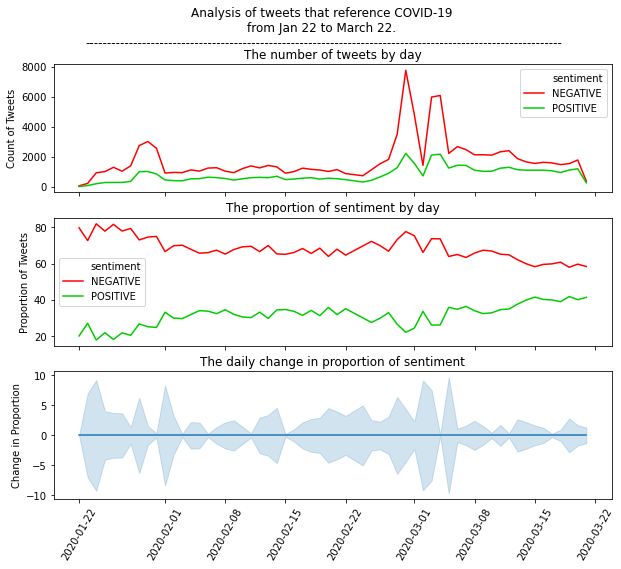

In [29]:
# Setting up data for plot 1 ########

# getting counts for each date -> sentiment
plot_data = raw.groupby(['date', 'sentiment']).count()['text'].reset_index()
# rename
plot_data.columns = ['date', 'sentiment', 'num_of_tweets']

# Setting up data for plot 2 ########

# getting sum of date -> sentiment
date_sent = plot_data.groupby(['date', 'sentiment']).agg({'num_of_tweets':'sum'})
# getting sum of dates
date = plot_data.groupby('date').agg({'num_of_tweets':'sum'})
# making proportion
prop_data = date_sent.div(date, level= 'date') * 100

# Setting up data for plot 3 #######

# finding differences in proportion
prop_data['diffs'] = prop_data.groupby(['sentiment'])['num_of_tweets'].transform(lambda x: x.diff())
prop_data = prop_data.reset_index()
# fill NaN value
prop_data['diffs'] = prop_data['diffs'].fillna(0)


# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19 \nfrom Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= plot_data, x= 'date', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax= ax[0])
plot = plot.set_title("The number of tweets by day")
plot = plt.xticks(rotation=60)
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= prop_data, x= 'date', y="num_of_tweets", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1]).set_title("The proportion of sentiment by day")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= prop_data, x= 'date', y="diffs", ax= ax[2]).set_title("The daily change in proportion of sentiment")
ax[2].set(ylabel='Change in Proportion')

# plot shared x axis
plot = plt.xlabel("")
plot = plt.xticks(rotation=60)



The second graph shows the proportion of sentiment each day, getting closer to 50% overtime. This also describes the probability that a tweet is positive or negative on any given day.

The third graph shows the daily changes in proportion, or how volatile the tweets are. With the biggest change nearing 10%.

Here is what this all means in terms of math.

$ A^{(j)} = \textit{ The event that } 
\left\{
    \begin{array}{ll}
        A^{(0)}  & \mbox{if sentiment is } negative  \\
        A^{(1)} & \mbox{if sentiment is } positive
    \end{array}
\right. | \mbox{ } A \subset tweets, \mbox{ } j \in \mathbb{Z}_2 $

$ B_n = \textit{ The event that a tweet occurs on } day_0, \mbox{ } ..., \mbox{ } day_n 
\mbox{ } | \mbox{ } \forall \textit{ days } \exists  \textit{ n, st. n} \in \mathbb{Z}_{ \textit{ max(days)} } $

<br />

$ P(A^{(j)}|B_n) = 
\left\{
    \begin{array}{ll}
        P(A^{(0)}|day_n) = 100 \bullet ( \frac{ A^{(0)} } { A^{(0)}+A^{(1)} } ) \\
        P(A^{(1)}|day_n) = 100 \bullet ( \frac{ A^{(1)} } { A^{(1)}+A^{(0)} } )
    \end{array}
\right. $

$ \frac{d} {dB} P(A^{(j)}|B_n) = P(A^{(j)}|day_{n-1}) - P(A^{(j)}|day_{n}) \mbox{ }_\blacksquare $




## Number of Tweets Over a Day

Now lets take a at what the tweet distribution is over the course of any given 24 hour day.

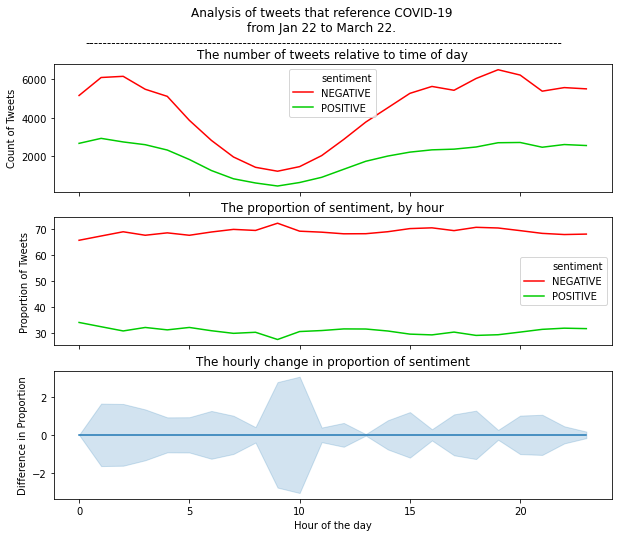

In [30]:
# Setting up data for plot 1 ########

# getting counts for hour -> sentiment
plot_data = raw.groupby(['hour', 'sentiment']).count()['text'].reset_index()
# renaming
plot_data.columns = ['hour', 'sentiment', 'num_of_tweets']

# Setting up data for plot 2 ########

# getting sum of hour -> sentiment
hour_sent = plot_data.groupby(['hour', 'sentiment']).agg({'num_of_tweets':'sum'})
# getting sum of hour
hour = plot_data.groupby('hour').agg({'num_of_tweets':'sum'})
# making proportion
prop_data = hour_sent.div(hour, level= 'hour') * 100

# Setting up data for plot 3 ########

# finding difference in proportion
prop_data['diffs'] = prop_data.groupby(['sentiment'])['num_of_tweets'].transform(lambda x: x.diff())
prop_data = prop_data.reset_index()
# fill NaN value
prop_data['diffs'] = prop_data['diffs'].fillna(0)

# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19 \nfrom Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= plot_data, x= 'hour', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax=ax[0])
plot = plot.set_title("The number of tweets relative to time of day")
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= prop_data, x= 'hour', y="num_of_tweets", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1]).set_title("The proportion of sentiment, by hour")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= prop_data, x= 'hour', y="diffs", ax= ax[2]).set_title("The hourly change in proportion of sentiment")
ax[2].set(ylabel='Difference in Proportion')

# plot shared x axis
plot = plt.xlabel("Hour of the day")

These graphs describe the same as last time, however it is modified for the time of day the tweet was posted, rather than the day itself.

As shown there seems to be a large dip from hour 6 to hour 12. This suggests that a lot of people are not tweeting about COVID-19 from 6am to 12pm.

However, the proportion of positive and negative sentiment tweets is very stable throughout the day, with the highest change being around 3%. Again, this also describes the probability of any given tweet for any hour of the day.

Here is what this means in math.

$ A^{(j)} = 
\left\{
    \begin{array}{ll}
        A^{(0)}  & \mbox{if sentiment is } negative  \\
        A^{(1)} & \mbox{if sentiment is } positive
    \end{array}
\right. | \mbox{ } A \subset tweets, \mbox{ } j \in \mathbb{Z}_2 $

$ B_n = \textit{ The event that a tweet occurs on } hour_0, \mbox{ } ..., \mbox{ } hour_n 
\mbox{ } | \mbox{ } \forall \textit{ hours } \exists  \textit{ n, st. n} \in \mathbb{Z}_{ 24 } $

<br />

$ P(A^{(j)}|B_n) = 
\left\{
    \begin{array}{ll}
        P(A^{(0)}|hour_n) = 100 \bullet ( \frac{ A^{(0)} } { A^{(0)}+A^{(1)} } ) \\
        P(A^{(1)}|hour_n) = 100 \bullet ( \frac{ A^{(1)} } { A^{(1)}+A^{(0)} } )
    \end{array}
\right. $

$ \frac{d} {dB} P(A^{(j)}|B_n) = P(A^{(j)}|day_{n-1}) - P(A^{(j)}|day_{n}) \mbox{ }_\blacksquare $



GRAPH FOR RELATION BETWEEN HASHTAGS AND MENTIONS

OR JUST MENTIONS and HASHTAGS SEPERATELY

## More Questions

time is in universal timezone, will need to be changed!!

* wait until places are figured out, will be cleaner

Barchart of verbs and ner. wordcloud?? adjectives?

* clean text first, make script before flair is processed

anything in particular, trump sentiment? china sentiment? masks? ect.

* make function to pass list of words, return tweets

get states and cities, barchart top states, sentiment by state?

* already done?? find out tuesday

get dates for major reform? correlation to number of tests, number of cases, deaths?

* good idea, will be some of the last steps of analysis

scrape more tweets? //////////

* will be done till end of may ////////


## Things to add

FINAL DATASET ADDS

* timezone
    + set to UTC, must manually change
    + also add hour modifications as column based on timezone

* english for flair /////////////
    + filter df ////////////////

* corrected place
    + state, city, county, ect

* fixed text, before flair /////////
    + remove hyperlinks, punctuation, special char ///////

* fixed text, after flair ///////////
    + remove stopwords /////////
    + change to stemming //////////////
    
* extra data
    + hashtags, mentions ///////////
    + language //////////
    + changed text /////////
    + timezone
    + hour modifications